# Ride Duration Prediction 

The objective is to predict the duration of a trip in a taxi ride. The data is given taken from TLC taxi trips data in the following website https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/arun-ubuntu/mlops_course/mlops-course/notebooks/experiment_tracking/mlruns/1', creation_time=1692644729465, experiment_id='1', last_update_time=1692644729465, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

> Run mlflow ui command using `mlflow ui --backend-store-uri sqlite:///mflow.db`

In [35]:
# trying to read parquet files 

df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")

In [36]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


> Pick up time, drop off time, Pick up location ID, drop off location id, trip distance are all important features

In [37]:
# filtering data by trip type as dispatch (online booking)

df[df.trip_type == 2]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5.0,265,265,1.0,0.00,180.0,0.0,0.0,36.06,0.0,None,0.3,216.36,1.0,2.0,0.0
15,2,2021-01-01 00:29:05,2021-01-01 00:29:07,N,5.0,42,264,1.0,0.00,10.0,0.0,0.0,2.06,0.0,None,0.3,12.36,1.0,2.0,0.0
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,0.0,0.0,0.00,0.0,None,0.3,13.30,2.0,2.0,0.0
43,2,2021-01-01 23:12:41,2021-01-02 01:13:53,N,5.0,95,82,1.0,0.00,9.7,0.0,0.0,2.00,0.0,None,0.3,12.00,1.0,2.0,0.0
45,2,2021-01-01 01:49:29,2021-01-01 01:49:33,N,5.0,244,244,5.0,0.02,12.0,0.0,0.0,2.46,0.0,None,0.3,14.76,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40363,2,2021-01-31 19:26:20,2021-01-31 19:35:47,N,5.0,167,248,2.0,1.31,10.0,0.0,0.0,0.00,0.0,None,0.3,10.30,2.0,2.0,0.0
40364,2,2021-01-31 19:44:54,2021-01-31 20:19:56,N,5.0,147,147,2.0,6.97,30.0,0.0,0.0,0.00,0.0,None,0.3,30.30,2.0,2.0,0.0
40377,2,2021-01-31 20:09:41,2021-01-31 20:10:21,N,5.0,95,95,1.0,0.00,15.0,0.0,0.0,3.06,0.0,None,0.3,18.36,1.0,2.0,0.0
40394,2,2021-01-31 20:38:42,2021-01-31 20:38:45,N,5.0,75,264,1.0,0.00,5.0,0.0,0.0,0.20,0.0,None,0.3,5.50,1.0,2.0,0.0


> We need a trip duration feature as a label in our dataset, so subtracting drop off time from pick up time

In [38]:
df.lpep_dropoff_datetime - df.lpep_pickup_datetime

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Length: 76518, dtype: timedelta64[ns]

In [39]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

**But the duration format cannot be taken as a target variable directly, better measure is to extract minutes from the duration as use it as target variable**

In [40]:
df.duration.iloc[0]

Timedelta('0 days 00:03:56')

In [41]:
tf = df.duration.iloc[0]

In [42]:
tf.total_seconds()

236.0

In [43]:
# converting seconds to minutes

tf.total_seconds() /  60

3.933333333333333

In [44]:
df['duration'] = df.duration.apply(lambda tf: tf.total_seconds() / 60)

In [45]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [46]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/tmp/ipykernel_14917/580505700.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

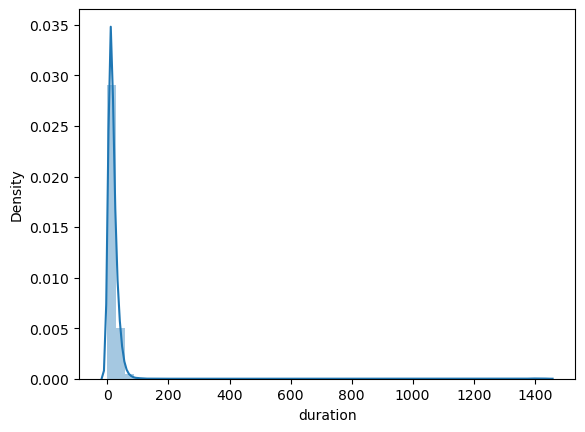

In [47]:
# checking distribution of target variable

sns.distplot(df.duration)

In [48]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

> 98% of the taxi rides are below 1 hour

In [50]:
df = df[(df.duration >= 1) & (df.duration <= 60)] 

In [51]:
df.shape


(73908, 21)

In [52]:
# reducing the dataset for simplicity 

categorical = ['PULocationID', 'DOLocationID']
numeric = ['trip_distance']

In [53]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [54]:
# converting into string 

df[categorical].astype('str')

,PULocationID,DOLocationID
0,43,151
1,166,239
2,41,42
3,168,75
7,75,75
...,...,...
76513,81,90
76514,35,213
76515,74,69
76516,168,215


In [55]:
df[categorical] =  df[categorical].astype('str')

/tmp/ipykernel_14917/118588339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] =  df[categorical].astype('str')


In [57]:
df[categorical + numeric].dtypes

PULocationID      object
DOLocationID      object
trip_distance    float64
dtype: object

In [58]:
# converting dataframe into dictionary of records 

df[categorical + numeric].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [63]:
train_dicts = df[categorical + numeric].to_dict(orient='records')

In [64]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


In [65]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [69]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [70]:
# target variable 

y_train = df['duration']
y_train

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [72]:
# training model on data 

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [73]:
lr.score(X_train, y_train)

0.27600290287598195

In [74]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_14917/2227337679.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='predictions')
/tmp/ipykernel_14917/2227337679.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='true values')


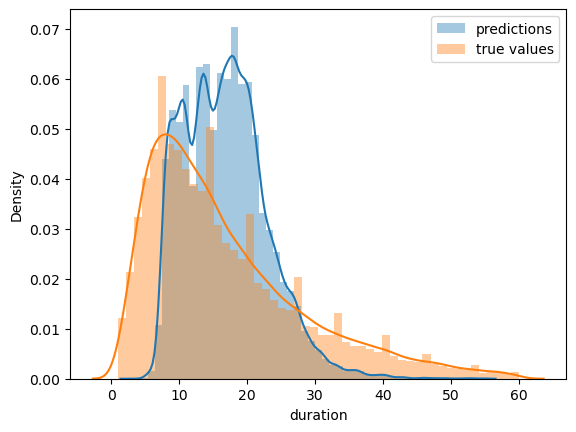

In [75]:
# visualizing the results 

sns.distplot(y_pred, label='predictions')
sns.distplot(y_train, label='true values')
plt.legend()

In [77]:
# performance metrics

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

> The model gives estimate of + or - 9.83 minutes from original duration, so the model is not a perfect model as we cosnidered trips only in range from 1 to 60 mins and deviation of 9.8 mins will decrease the customer experience

### Code Restructuring and train validation evaluation

In [3]:
def read_process_df(filename):

    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda tf: tf.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)] 

    categorical = ['PULocationID', 'DOLocationID']
    numeric = ['trip_distance']
    df[categorical] =  df[categorical].astype('str')
    
    return df
    

In [4]:
train_df = read_process_df("./data/green_tripdata_2021-01.parquet")
val_df = read_process_df("./data/green_tripdata_2021-02.parquet")

In [5]:
train_df.shape, val_df.shape

((73908, 21), (61921, 21))

In [6]:
train_df['PU_DO'] = train_df['PULocationID'] + "_" + train_df['DOLocationID']
val_df['PU_DO'] = val_df['PULocationID'] + "_" + val_df['DOLocationID']

In [7]:
dv = DictVectorizer()
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numeric = ['trip_distance']

train_dicts = train_df[categorical + numeric].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = train_df['duration'] 

val_dicts = val_df[categorical + numeric].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = val_df['duration'] 


print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(73908, 13221) (61921, 13221) (73908,) (61921,)


In [30]:
# training Linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
train_rmse = mean_squared_error(y_pred, y_train, squared=False)
print("Training RMSE score: ", train_rmse)

y_pred = lr.predict(X_val)
val_rmse = mean_squared_error(y_pred, y_val, squared=False)
print("Validation RMSE score: ", val_rmse)



Training RMSE score:  5.699564118199053
Validation RMSE score:  7.758715198889101


In [8]:
# training Lasso model

lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
train_rmse = mean_squared_error(y_pred, y_train, squared=False)
print("Training RMSE score: ", train_rmse)

y_pred = lr.predict(X_val)
val_rmse = mean_squared_error(y_pred, y_val, squared=False)
print("Validation RMSE score: ", val_rmse)

Training RMSE score:  8.345478908061276
Validation RMSE score:  9.233436225720547


In [11]:
# training Ridge model

lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
train_rmse = mean_squared_error(y_pred, y_train, squared=False)
print("Training RMSE score: ", train_rmse)

y_pred = lr.predict(X_val)
val_rmse = mean_squared_error(y_pred, y_val, squared=False)
print("Validation RMSE score: ", val_rmse)

Training RMSE score:  5.645810929236537
Validation RMSE score:  7.703735120077197


**After including Pick up location ID and drop off location ID as a combined feature, there is improvement in the model because both ID are known while a passenger boards a taxi. The performance of model is good with inluding this as a feature. Clearly Ridge and Linear are the best model. Choosing Linear model as the best model for further development**

In [11]:
# saving the best model with dict vectorizer

with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

# Experimentation and tracking using MLFlow

In [9]:
# a simple example with mlflow

with mlflow.start_run():

    mlflow.set_tag("creator", "Arun")

    alpha = 0.1

    # logging input datatsets path so it may be useful
    mlflow.log_param("train_dataset_path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation_dataset_path", "./data/green_tripdata_2021-02.parquet")

    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha= alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
    train_rmse = mean_squared_error(y_pred, y_train, squared=False)
    print("Training RMSE score: ", train_rmse)
    mlflow.log_metric("rmse", train_rmse)


    y_pred = lr.predict(X_val)
    val_rmse = mean_squared_error(y_pred, y_val, squared=False)
    print("Validation RMSE score: ", val_rmse)

Training RMSE score:  11.496877490739017
Validation RMSE score:  12.143233939663894
